In [1]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics

In [2]:
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))
#stopwords_list

In [3]:
train_data = pd.read_csv("train_data.csv")
train_results = pd.read_csv("train_results.csv")
test_data = pd.read_csv("test_data.csv")

In [4]:
print(len(train_data))
print(len(test_data))

1040323
560175


In [5]:
train_data

,id,text
0,0,Anyway Im getting of for a while
1,1,"My red, Apache isn't feelin too well this morn..."
2,2,@danyelljoy you should be its great. friday w...
3,3,its 11:30pm and i dont wanna sleep; so i debat...
4,4,Why does twitter eat my DM's? Not happy
...,...,...
1040318,1040318,getting ready 2 watch mental
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...


In [6]:
train_data.isnull().sum()

id      0
text    0
dtype: int64

In [7]:
test_data

,id,text
0,0,so cut... missed out on all the TCE EXTREME ME...
1,1,Thank you very much Wasin this is awesome lol
2,2,Squeezing in some internet time before Dustin ...
3,3,@fanoou; Oh i do have moral but i'm gonna be b...
4,4,@NSuissa I just bought Sammy some joint/hip ...
...,...,...
560170,560170,@meganintime So is mine and I've only got abou...
560171,560171,@FairyForest Thanks cutie ) Wishing u a wonder...
560172,560172,ok know i just got home my family just drop me...
560173,560173,long run status: complete. Now time for church...


In [8]:
test_data['text']

0         so cut... missed out on all the TCE EXTREME ME...
1            Thank you very much Wasin  this is awesome lol
2         Squeezing in some internet time before Dustin ...
3         @fanoou; Oh i do have moral but i'm gonna be b...
4         @NSuissa   I just bought Sammy some joint/hip ...
                                ...                        
560170    @meganintime So is mine and I've only got abou...
560171    @FairyForest Thanks cutie ) Wishing u a wonder...
560172    ok know i just got home my family just drop me...
560173    long run status: complete. Now time for church...
560174    @textualoffender Doestovesky yes,remaining 3 w...
Name: text, Length: 560175, dtype: object

In [9]:
full_train_label = train_results['target'].replace(['negative' , 'neutral', 'positive'] , [0,1,2])
train_target = pd.DataFrame(full_train_label)
train_target

,target
0,2
1,0
2,2
3,2
4,0
...,...
1040318,2
1040319,0
1040320,0
1040321,2


In [10]:
full_train_label.value_counts()

2    520436
0    519803
1        84
Name: target, dtype: int64

In [11]:
train_results['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [12]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=  text.strip()  
    text=  re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Removes url
    text = re.compile(r'<[^>]+>').sub('', text) #Removes HTML tags:
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Single character removal
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    #return lemmatizer(stopword(preprocess(string)))
    return lemmatizer(preprocess(string))

In [13]:
train_data['clean_text']=train_data['text'].map(lambda s:preprocess(s)) 
train_data

,id,text,clean_text
0,0,Anyway Im getting of for a while,anyway im getting of for while
1,1,"My red, Apache isn't feelin too well this morn...",my red apache isn feelin too well this morning...
2,2,@danyelljoy you should be its great. friday w...,danyelljoy you should be its great friday will...
3,3,its 11:30pm and i dont wanna sleep; so i debat...,its pm and dont wanna sleep so debated with my...
4,4,Why does twitter eat my DM's? Not happy,why does twitter eat my dm not happy
...,...,...,...
1040318,1040318,getting ready 2 watch mental,getting ready watch mental
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...,wristcutters and half nelson are on sundance f...
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...,t isfortammy going out in northbridge makes me...
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...,imodel lol gorgeous lol look sooo much like th...


In [14]:
df_clean = pd.DataFrame(train_data['clean_text'])
df_clean

,clean_text
0,anyway im getting of for while
1,my red apache isn feelin too well this morning...
2,danyelljoy you should be its great friday will...
3,its pm and dont wanna sleep so debated with my...
4,why does twitter eat my dm not happy
...,...
1040318,getting ready watch mental
1040319,wristcutters and half nelson are on sundance f...
1040320,t isfortammy going out in northbridge makes me...
1040321,imodel lol gorgeous lol look sooo much like th...


In [15]:
df_clean = pd.concat([df_clean, train_target], axis=1)

df_clean.to_csv('train_cleaned_text_target_final_rani.csv')

In [16]:
df_clean

,clean_text,target
0,anyway im getting of for while,2
1,my red apache isn feelin too well this morning...,0
2,danyelljoy you should be its great friday will...,2
3,its pm and dont wanna sleep so debated with my...,2
4,why does twitter eat my dm not happy,0
...,...,...
1040318,getting ready watch mental,2
1040319,wristcutters and half nelson are on sundance f...,0
1040320,t isfortammy going out in northbridge makes me...,0
1040321,imodel lol gorgeous lol look sooo much like th...,2


In [17]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_clean["clean_text"],df_clean["target"],test_size=0.2,shuffle=True, random_state=8)

In [18]:
X_train

198662    jlneveloff want to go too quinto too bad we re...
198588    what do you guys think of this laptop http is ...
497233    thecoveted boo their name seemed so familiar w...
850715    staying in because a dicky tummy and feel bit ...
592604    listing to my pod and slept my neck wrong so i...
                                ...                        
231557      mrcakey hope you have beer to keep you cool too
780649    envisioning photo campaign ugly organic food t...
149489    chillin in la still dont know when m goin home...
550228              tonesa we re tryina find somethin to do
594371                              watta so busy right now
Name: clean_text, Length: 832258, dtype: object

Naive Bayes


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.80      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[83511     0 20136]
 [    1     0    10]
 [21882     0 82525]]
accuracy: 0.7980006248047485


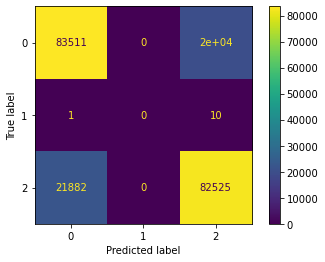

In [19]:
# vectorization using Bag-of-Words (with Tf-Idf ) and Word2Vec
#Tf-Idf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=150000, ngram_range=(1,3))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84069     0 19578]
 [    1     0    10]
 [17880     0 86527]]
accuracy: 0.8199168529065436


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


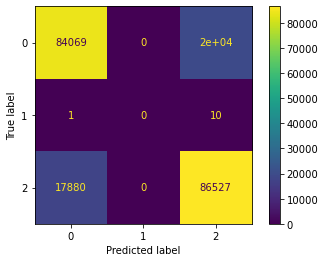

In [20]:
from sklearn.linear_model import LogisticRegression

print("Logistic Regression ")

# Logistic Regression tf-idf)
lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[83722     0 19925]
 [    1     0    10]
 [21767     0 82640]]
accuracy: 0.7995674428664119


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


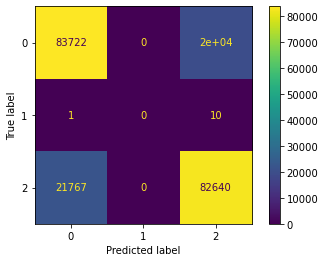

In [21]:
# vectorization using Bag-of-Words (with Tf-Idf ) 

tfidf_vectorizer = TfidfVectorizer(max_features=200000, ngram_range=(1,3))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84125     0 19522]
 [    1     0    10]
 [17843     0 86564]]
accuracy: 0.8203638286112513


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


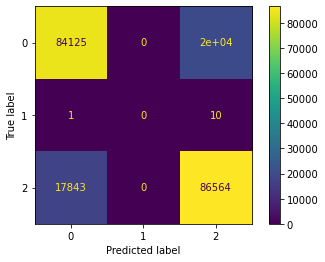

In [22]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)
print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[83961     0 19686]
 [    1     0    10]
 [22200     0 82207]]
accuracy: 0.798635041934011


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


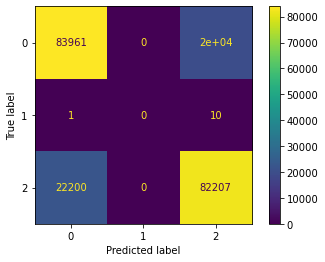

In [23]:
# vectorization using Bag-of-Words (with Tf-Idf ) 


tfidf_vectorizer = TfidfVectorizer(max_features=150000, ngram_range=(1,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()



Logistic Regression 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[83999     0 19648]
 [    1     0    10]
 [17914     0 86493]]
accuracy: 0.8194170091077307


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


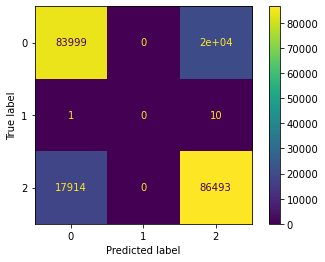

In [24]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)
print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[84156     0 19491]
 [    1     0    10]
 [22162     0 82245]]
accuracy: 0.7997548842909667


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


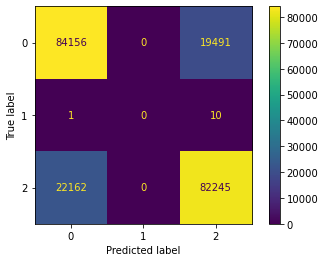

In [25]:
# vectorization using Bag-of-Words (with Tf-Idf ) 


tfidf_vectorizer = TfidfVectorizer(max_features=200000, ngram_range=(1,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84045     0 19602]
 [    1     0    10]
 [17845     0 86562]]
accuracy: 0.8199697210006488


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


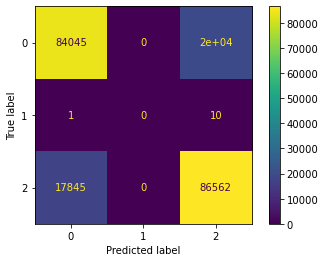

In [26]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[83943     0 19704]
 [    1     0    10]
 [21734     0 82673]]
accuracy: 0.8007882152212049


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


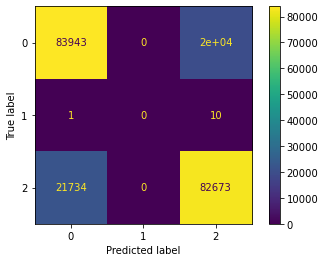

In [27]:
# vectorization using Bag-of-Words (with Tf-Idf ) 


tfidf_vectorizer = TfidfVectorizer(max_features=300000, ngram_range=(1,3))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

Logistic Regression 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84241     0 19406]
 [    1     0    10]
 [17799     0 86608]]
accuracy: 0.8211328190709634


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


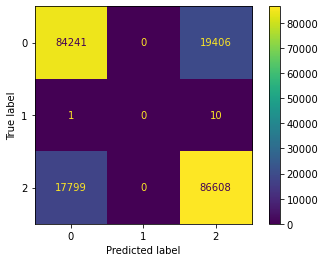

In [28]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.79      0.80    104407

    accuracy                           0.80    208065
   macro avg       0.53      0.53      0.53    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[84044     0 19603]
 [    1     0    10]
 [21703     0 82704]]
accuracy: 0.8014226323504674


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


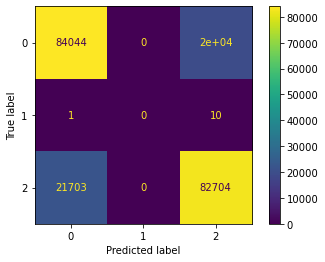

In [29]:
# vectorization using Bag-of-Words (with Tf-Idf ) 


tfidf_vectorizer = TfidfVectorizer(max_features=400000, ngram_range=(1,3))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

print("Naive Bayes")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

Logistic Regression 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84308     0 19339]
 [    1     0    10]
 [17799     0 86608]]
accuracy: 0.8214548338259678


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


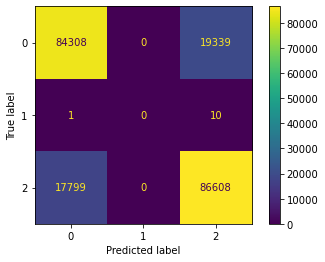

In [30]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()



## Hyperparamter Search C values

In [31]:

tfidf_vectorizer = TfidfVectorizer(max_features=200000, ngram_range=(1,3))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

Logistic Regression 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75    103647
           1       0.00      0.00      0.00        11
           2       0.76      0.72      0.74    104407

    accuracy                           0.74    208065
   macro avg       0.50      0.50      0.50    208065
weighted avg       0.74      0.74      0.74    208065

Confusion Matrix: [[79294     0 24353]
 [    1     0    10]
 [29053     0 75354]]
accuracy: 0.7432677288347391


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


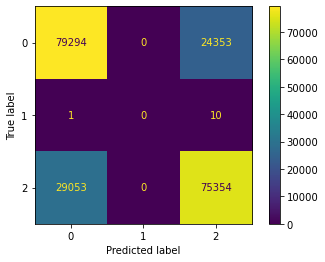

In [32]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=0.001, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    103647
           1       0.00      0.00      0.00        11
           2       0.78      0.78      0.78    104407

    accuracy                           0.78    208065
   macro avg       0.52      0.52      0.52    208065
weighted avg       0.78      0.78      0.78    208065

Confusion Matrix: [[80751     0 22896]
 [    1     0    10]
 [22835     0 81572]]
accuracy: 0.7801552399490543


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


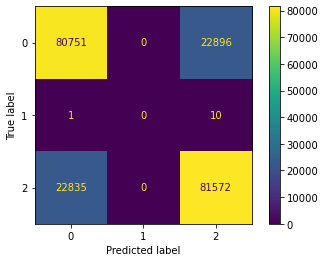

In [33]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=0.01, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.81      0.80      0.81    103647
           1       0.00      0.00      0.00        11
           2       0.81      0.82      0.81    104407

    accuracy                           0.81    208065
   macro avg       0.54      0.54      0.54    208065
weighted avg       0.81      0.81      0.81    208065

Confusion Matrix: [[83151     0 20496]
 [    1     0    10]
 [18933     0 85474]]
accuracy: 0.8104438516809651


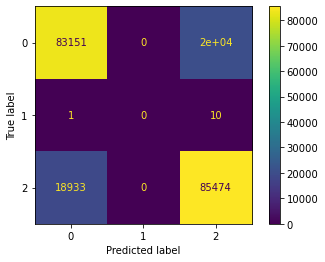

In [34]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=0.1, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 


C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82    103647
           1       0.00      0.00      0.00        11
           2       0.82      0.83      0.82    104407

    accuracy                           0.82    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.82      0.82      0.82    208065

Confusion Matrix: [[84125     0 19522]
 [    1     0    10]
 [17843     0 86564]]
accuracy: 0.8203638286112513


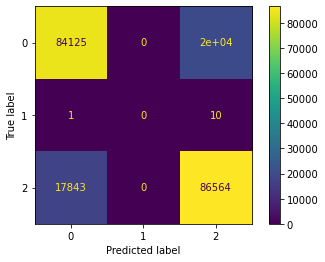

In [35]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=1.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80    103647
           1       0.00      0.00      0.00        11
           2       0.80      0.81      0.81    104407

    accuracy                           0.80    208065
   macro avg       0.54      0.54      0.54    208065
weighted avg       0.80      0.80      0.80    208065

Confusion Matrix: [[82611     0 21036]
 [    1     0    10]
 [19667     1 84739]]
accuracy: 0.8043159589551342


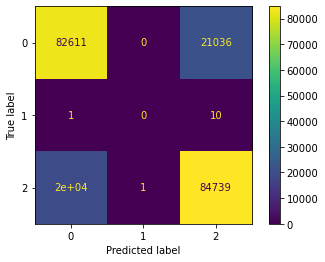

In [36]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=10.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()


Logistic Regression 
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    103647
           1       0.00      0.00      0.00        11
           2       0.78      0.78      0.78    104407

    accuracy                           0.78    208065
   macro avg       0.52      0.52      0.52    208065
weighted avg       0.78      0.78      0.78    208065

Confusion Matrix: [[80330     0 23317]
 [    1     0    10]
 [22508     1 81898]]
accuracy: 0.7796986518636003


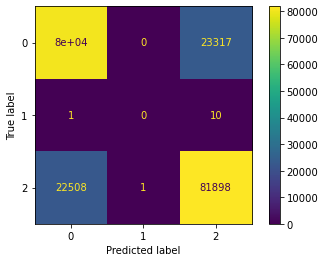

In [37]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)

print("Logistic Regression ")

lr  = LogisticRegression(C=100.0, max_iter=5000)
lr.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr.predict(X_test_vectors_tfidf)
y_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]

cf_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',cf_matrix)

print("accuracy:", metrics.accuracy_score(y_test, y_predict))


disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()
